## Data Mining Project -- XGBoost

In [91]:
# Libraries for processing the data
import numpy as np
import pandas as pd

# Libraries to understand the data through graphs/plots
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from IPython.display import Image  
import pydotplus

# Scikit learn libraries to model the data and try out some normal
# Decision Tree algorithms without boosting to compart accuracy results
# We will be testing both DecisionTreeCLassifier and RandomForestClassifier 
# To see how XGBoost evolved from them, before ultimately using XGBoost.
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder as lab
from scipy.stats import randint
from sklearn.externals import joblib
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score as ac
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

# XGBoost library
import xgboost as xgb

# Changing SNS color palette to bright
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("bright"))

#Other python helper libraries
import re

# Mental Health Dataset

We will be using the mental health dataset, from the 2014 survey hosted by OSMI called "Mental Health in Tech" which had over 1200 responses. 

##### Here the target is to predict whether the employee has taken treatment for mental health or not based on the other factors submitted in the survey. 

(link: https://docs.google.com/spreadsheets/d/1cr65P3ciL2tD4W4KOCTz4Ik67iD52S_DKHXypqgta2o/edit#gid=1001406186)


In [92]:
df=pd.read_csv('C:\\Users\\Chandu\\Documents\\survey.csv')
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [93]:
# Split the datasets for classification
x = df
y = df['treatment']
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [94]:
print(xTrain.shape, xTest.shape)

(1007, 27) (252, 27)


### Basic Cleaning

Here we can see one attribute that we can just remove directly, the timestamp attribute. There is obviously not going to be any connection between the time of submission of survey and the target.

In [95]:
# Drop the Timestamp attribute
df = df.drop(['Timestamp'], 1)

We have noticed that the comments attribute is mostly NaN, but lets take a look at how many exactly.

["Don't know" 'Risk'] [1176   83]


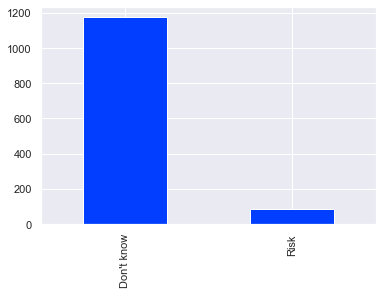

In [96]:
commentRegex =  r"^.*(?:Neurological|drugs|issues|mental health|depression|disorder).*$"
a=np.array(df.comments)
for i in range(len(a)):
    if not pd.isnull(a[i]):
        m=re.search(commentRegex,a[i])
        if m!=None:
            a[i]="Risk"
        else:
            a[i]="Don't know"
    else:
        a[i]="Don't know"
df["comments"]=a
a,b = np.unique(df["comments"],return_counts=True)
print(a,b)
df.head(5)
df["comments"].value_counts().plot(kind="bar")

Since only 62 have at risk kind of words, it would play a negligible role in predicting, hence let's also drop the comments attribute.

In [97]:
df = df.drop(['comments'], 1)

In [98]:
df.head()

,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


### Lets do some more basic cleaning with regards to the other attributes. Let's first start out with Age and Gender.

In [99]:
# Dealing with NaNs before we can encode/ go further
# Using the pandas fillna function makes it very easy to fill some default values

# Assign default values for each data type
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']

# Clean the NaN's
for feature in df:
    if feature in intFeatures:
        df[feature] = df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        df[feature] = df[feature].fillna(defaultString)
    else:
        pass
df.head(5)   

,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


C:\Users\Chandu\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


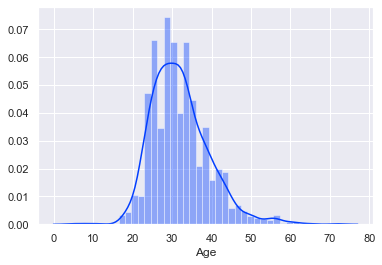

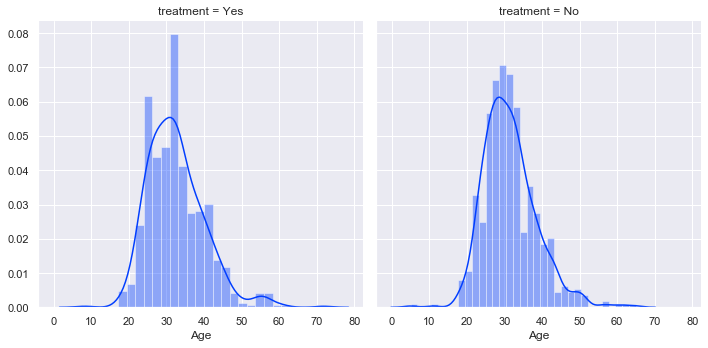

In [100]:
# Handling the age -- replacing ages >100 or <0 with MEDIAN

# ORIGINAL DATA
# [[-1726, 1], [-29, 1], [-1, 1], [5, 1], [8, 1], [11, 1], [18, 7], [19, 9], [20, 6], [21, 16], [22, 21], [23, 51], [24, 46], [25, 61], [26, 75], [27, 71], [28, 68], [29, 85], [30, 63], [31, 67], [32, 82], [33, 70], [34, 65], [35, 55], [36, 37], [37, 43], [38, 39], [39, 34], [40, 33], [41, 21], [42, 20], [43, 28], [44, 11], [45, 12], [46, 12], [47, 2], [48, 6], [49, 4], [50, 6], [51, 5], [53, 1], [54, 3], [55, 3], [56, 4], [57, 3], [58, 1], [60, 2], [61, 1], [62, 1], [65, 1], [72, 1], [329, 1]]

# a,b=np.unique(df.Age,return_counts=True)
# print([([a[i],b[i]]) for i in range(len(a))])

a = np.array(df.Age)
b = np.array(df.Age)
b = np.array([x for x in b if x>=0 and x<=100])
age_median = np.median(b)
for i in range(len(a)):
    if a[i]>100 or a[i]<0:
        a[i] = age_median
df["Age"] = a
# df.head(5)
sns.distplot(df["Age"]);
g = sns.FacetGrid(df, col='treatment', size=5)
g = g.map(sns.distplot, "Age")


[['F', 236], ['M', 971], ['O', 52]]


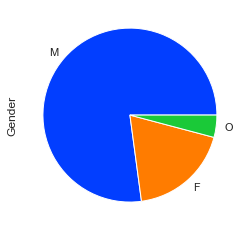

In [101]:
# For handling gender, we consider everything not in the Male/Female regex's in the category 'Other'.

# ORIGINAL DATA
# [['A little about you', 1], ['Agender', 1], ['Androgyne', 1], ['Cis Female', 1], ['Cis Male', 2], ['Cis Man', 1], ['Enby', 1], ['F', 38], ['Femake', 1], ['Female', 121], ['Female ', 2], ['Female (cis)', 1], ['Female (trans)', 2], ['Genderqueer', 1], ['Guy (-ish) ^_^', 1], ['M', 116], ['Mail', 1], ['Make', 4], ['Mal', 1], ['Male', 615], ['Male ', 4], ['Male-ish', 1], ['Malr', 1], ['Man', 2], ['Nah', 1], ['Neuter', 1], ['Trans woman', 1], ['Trans-female', 1], ['Woman', 3], ['cis male', 1], ['cis-female/femme', 1], ['f', 16], ['femail', 1], ['female', 63], ['fluid', 1], ['m', 34], ['maile', 1], ['male', 206], ['male leaning androgynous', 1], ['msle', 1], ['non-binary', 1], ['ostensibly male, unsure what that really means', 1], ['p', 1], ['queer', 1], ['something kinda male?', 1], ['woman', 1]]
# a,b=np.unique(df.Gender,return_counts=True)
# print([([a[i],b[i]]) for i in range(len(a))])

a = np.array(df.Gender)
regex = r"^(?:m|M|male|Male|f|F|female|Female)$"
mreg = r"^(?:m|M|male|Male)$"
freg = r"^(?:f|F|female|Female)$"
for i in range(len(a)):
    m = re.search(regex,a[i])
    if m!=None:
        m1 = re.search(mreg,a[i])
        if m1!=None:
            a[i]="M"
        else:
            a[i]="F"
    else:
        a[i]="O"
df["Gender"]=a
a,b=np.unique(df.Gender,return_counts=True)
print([([a[i],b[i]]) for i in range(len(a))])
df["Gender"].value_counts().plot(kind="pie")

Looks good, we handled both age and gender by considering median and a new value respectively. Let's handling the NaN cases in the other attributes now.

146 1095 0


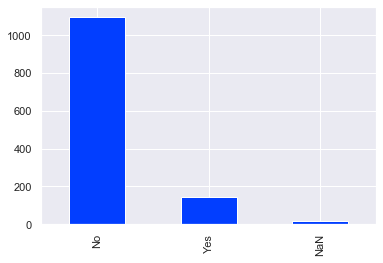

In [102]:
# Self Employed NaN handling -- Use the majority value --> NO in case of NaNs.

# ORIGINAL DATA
a = np.array(df.self_employed)
nYes = (a == "Yes").sum()
nNo = (a == "No").sum()
nNaN = (pd.isnull(a)).sum()
print(nYes,nNo,nNaN)
    
# handling
for i in range(len(a)):
    if pd.isnull(a[i]):
        '''c=np.random.randint(low=1, high=100)
        if(c<88):
            a[i]="Yes"
        else:
            a[i]="No"'''
        a[i]="No"
df["self_employed"]=a
df["self_employed"].value_counts().plot(kind="bar")

In [103]:
# Here for the state attribute, we have over 500 NaNs. It feels best to drop
# this attribute altogether, having almost 50% missing values.
a = np.array(df.state)
c = np.array(df.Country)
b = [x for x in a if not(pd.isnull(x))]
s = "Out"
nNaN = (pd.isnull(a)).sum()
print(nNaN)
df = df.drop(['state'], 1)

515


In [104]:
df.shape

(1259, 24)

## Understanding the data 

Let's take a look at the cleaned data now, and see if we can make out any obvious correlations or other insights.

In [105]:
df.head()

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,F,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,M,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,M,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,M,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


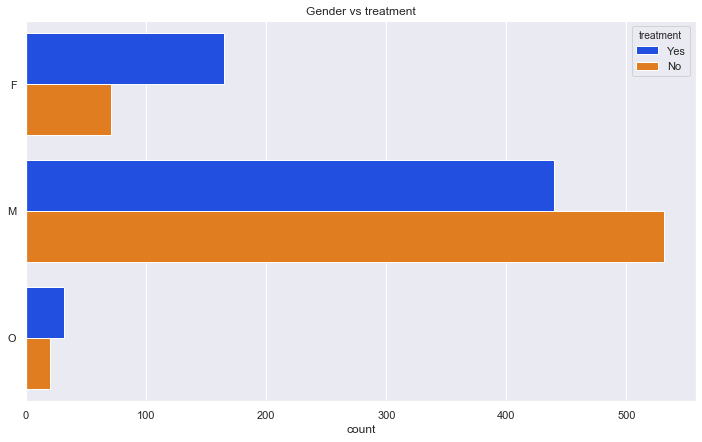

In [106]:
plt.figure(figsize=(12,7))
sns.countplot(y="Gender", hue="treatment", data=df)
plt.title("Gender vs treatment",fontsize=12)
plt.ylabel("")
plt.show()

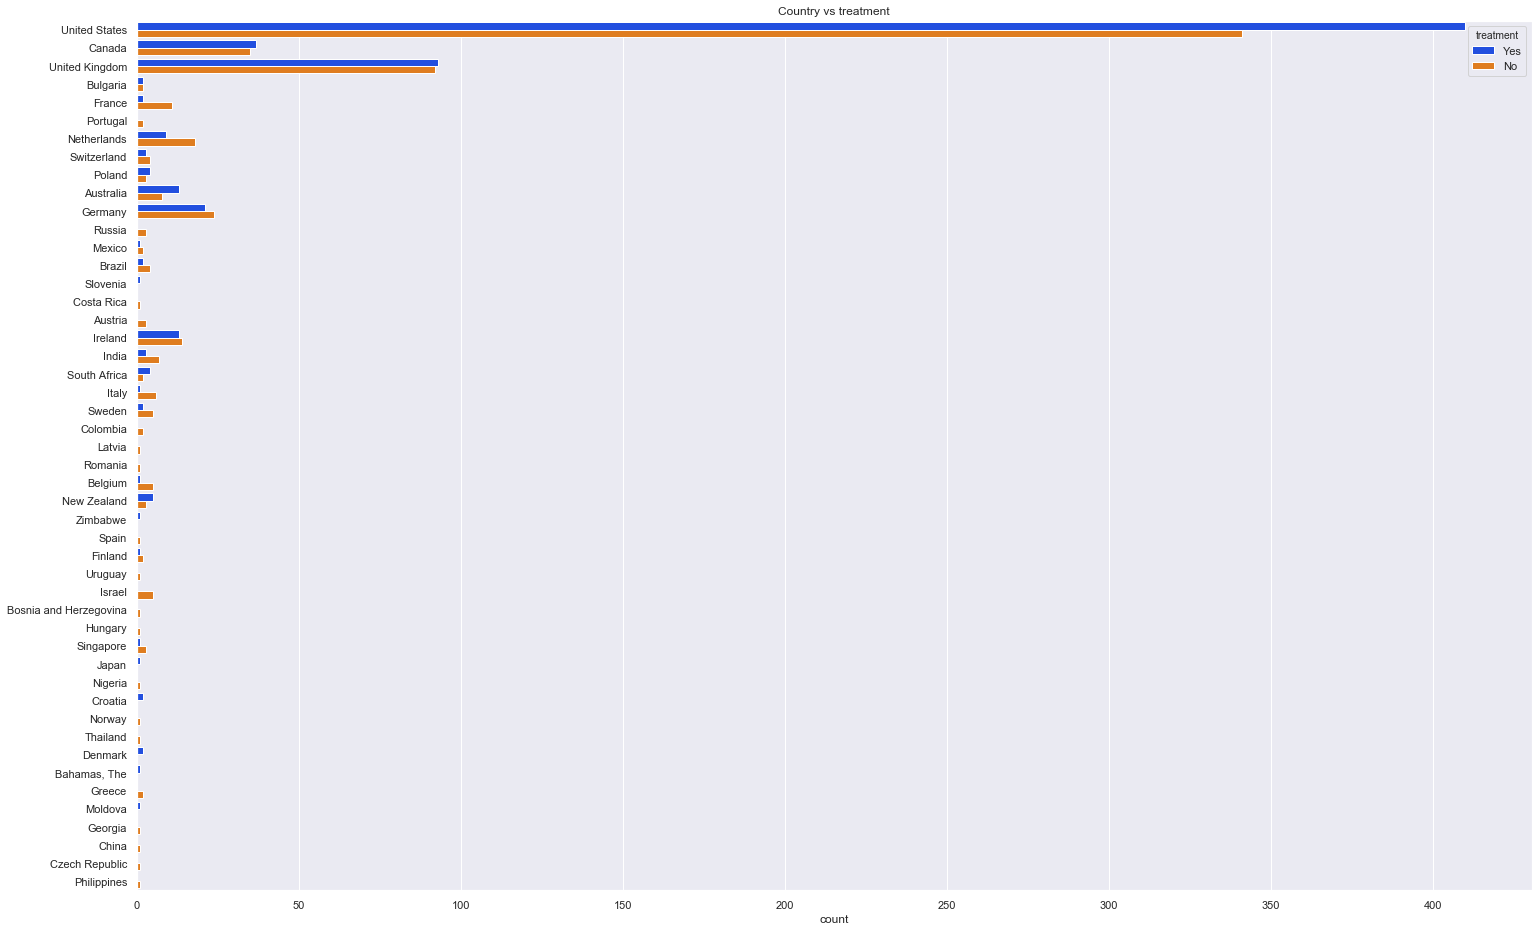

In [107]:
plt.figure(figsize=(25,16))
sns.countplot(y="Country", hue="treatment", data=df)
plt.title("Country vs treatment",fontsize=12)
plt.ylabel("")
plt.show()

In [108]:
# Encoding data using labelEncoder
labelDict = {}
for feature in df:
    le = preprocessing.LabelEncoder()
    le.fit(df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    df[feature] = le.transform(df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

df.head()

label_Age [5, 8, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['F', 'M', 'O']
label_Country ['Australia', 'Austria', 'Bahamas, The', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['NaN', 'No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ['NaN', 'Never', 'Often', 'Rarely', 'Sometimes'

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,22,0,45,0,0,1,2,4,0,1,...,2,2,1,1,1,2,1,0,2,0
1,29,1,45,0,0,0,3,5,0,0,...,0,0,0,1,0,0,1,1,0,0
2,17,1,7,0,0,0,3,4,0,1,...,0,1,1,1,2,2,2,2,1,0
3,16,1,44,0,1,1,2,2,0,1,...,1,1,2,2,1,0,0,0,1,1
4,16,1,45,0,0,0,1,1,1,1,...,0,0,1,1,1,2,2,2,0,0


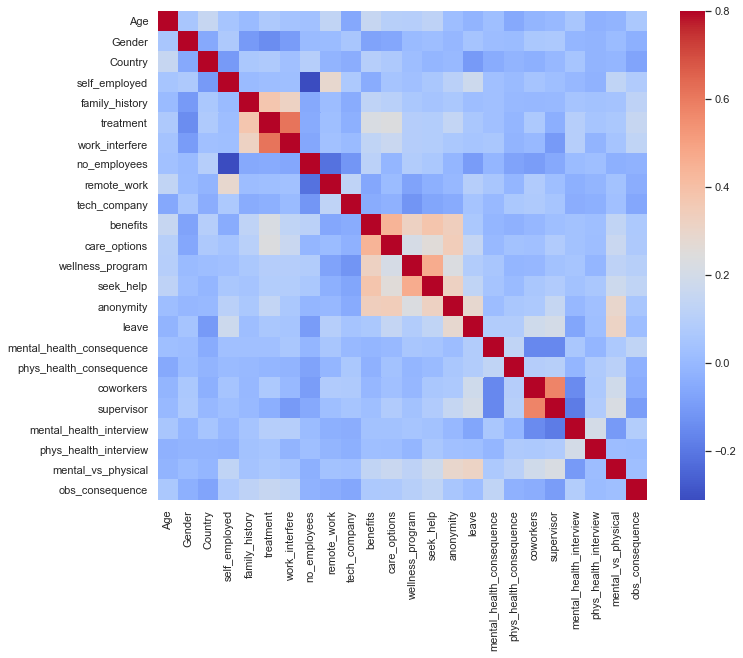

In [109]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap= 'coolwarm');
plt.show()

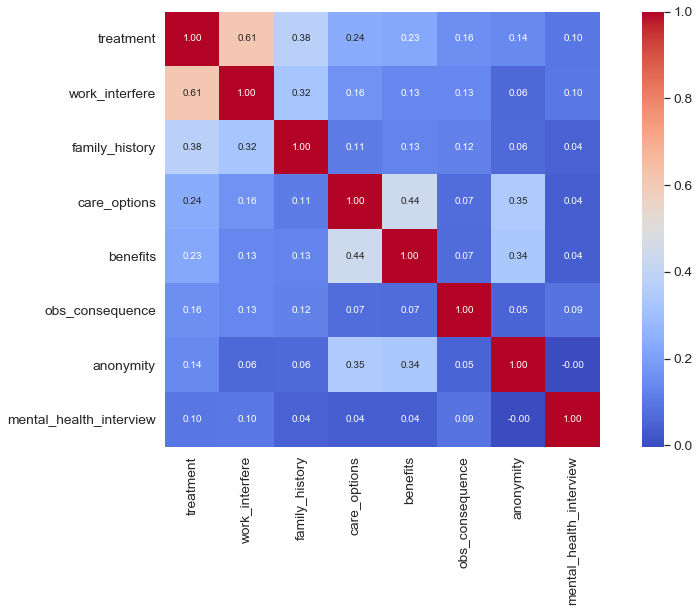

In [110]:
#treatment correlation matrix
plt.figure(figsize=(15,8))
k = 8 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap= 'coolwarm')
plt.show()

### Splitting the data set

In [111]:
feature_cols = ['Age','Gender','Country','self_employed','family_history', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence']

selected_feature_cols =['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']

X = df[selected_feature_cols]
y = df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

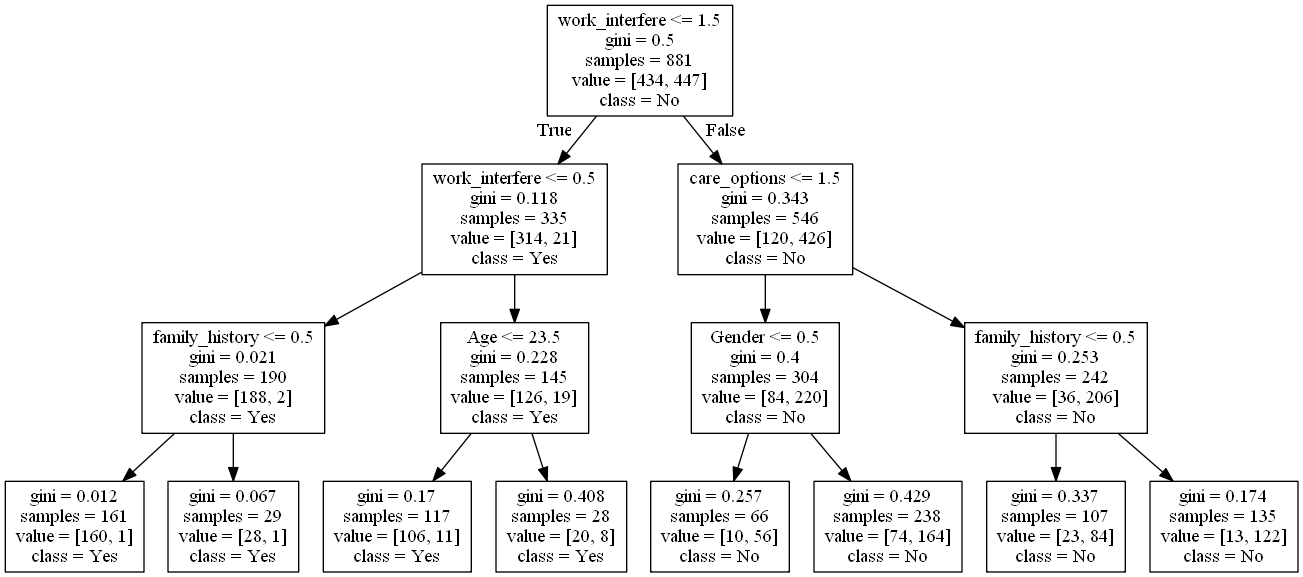

In [112]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=3, min_samples_split=8, max_features=6, criterion='gini', min_samples_leaf=7)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=selected_feature_cols,  class_names=['Yes', 'No'])
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
# Show graph
Image(graph.create_png())

In [113]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8095238095238095


Pros

->Decision trees are easy to interpret and visualize.

->It can easily capture Non-linear patterns.

Cons

->Sensitive to noisy data. It can overfit noisy data.

->The small variation(or variance) in data can result in the different decision tree. This can be reduced by bagging and         boosting algorithms.

->Decision trees are biased with imbalance dataset, so it is recommended that balance out the dataset before creating the         decision tree.

## XGBoost:

XGBoost (Extreme Gradient Boosting) belongs to a family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. Note that a weak learner is one which is slightly better than random guessing. For example, a decision tree whose predictions are slightly better than 50%. 


Common tuning parameters:

learning_rate:     step size shrinkage used to prevent overfitting. Range is [0,1]

max_depth:         determines how deeply each tree is allowed to grow during any boosting round.

subsample:         percentage of samples used per tree. Low value can lead to underfitting.

colsample_bytree:  percentage of features used per tree. High value can lead to overfitting.

n_estimators:      number of trees you want to build.

objective:         determines the loss function to be used like reg:linear for regression problems, 
reg:logistic       for classification problems with only decision, binary:logistic for classification problems with                                probability.

Model 0 Test Accuracy: 80.16%


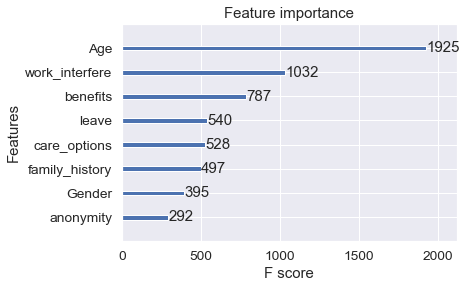

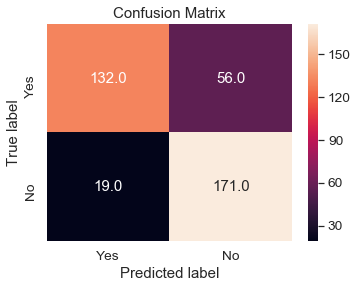

In [114]:
# Direct model with no tuning, basic parameters

model = xgb.XGBClassifier(learning_rate = 0.01, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = metrics.accuracy_score(y_test, predictions)
print("Model 0 Test Accuracy: %.2f%%" % (accuracy * 100.0))
xgb.plot_importance(model)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = ['Yes', 'No'], columns = ['Yes', 'No'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title('Confusion Matrix'.format(ac(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
plt.show()

# Precision = TP / (TP + FP) 
# Recall = TP / (TP + FN)
# fscore = 2/(1/r+1/p) 

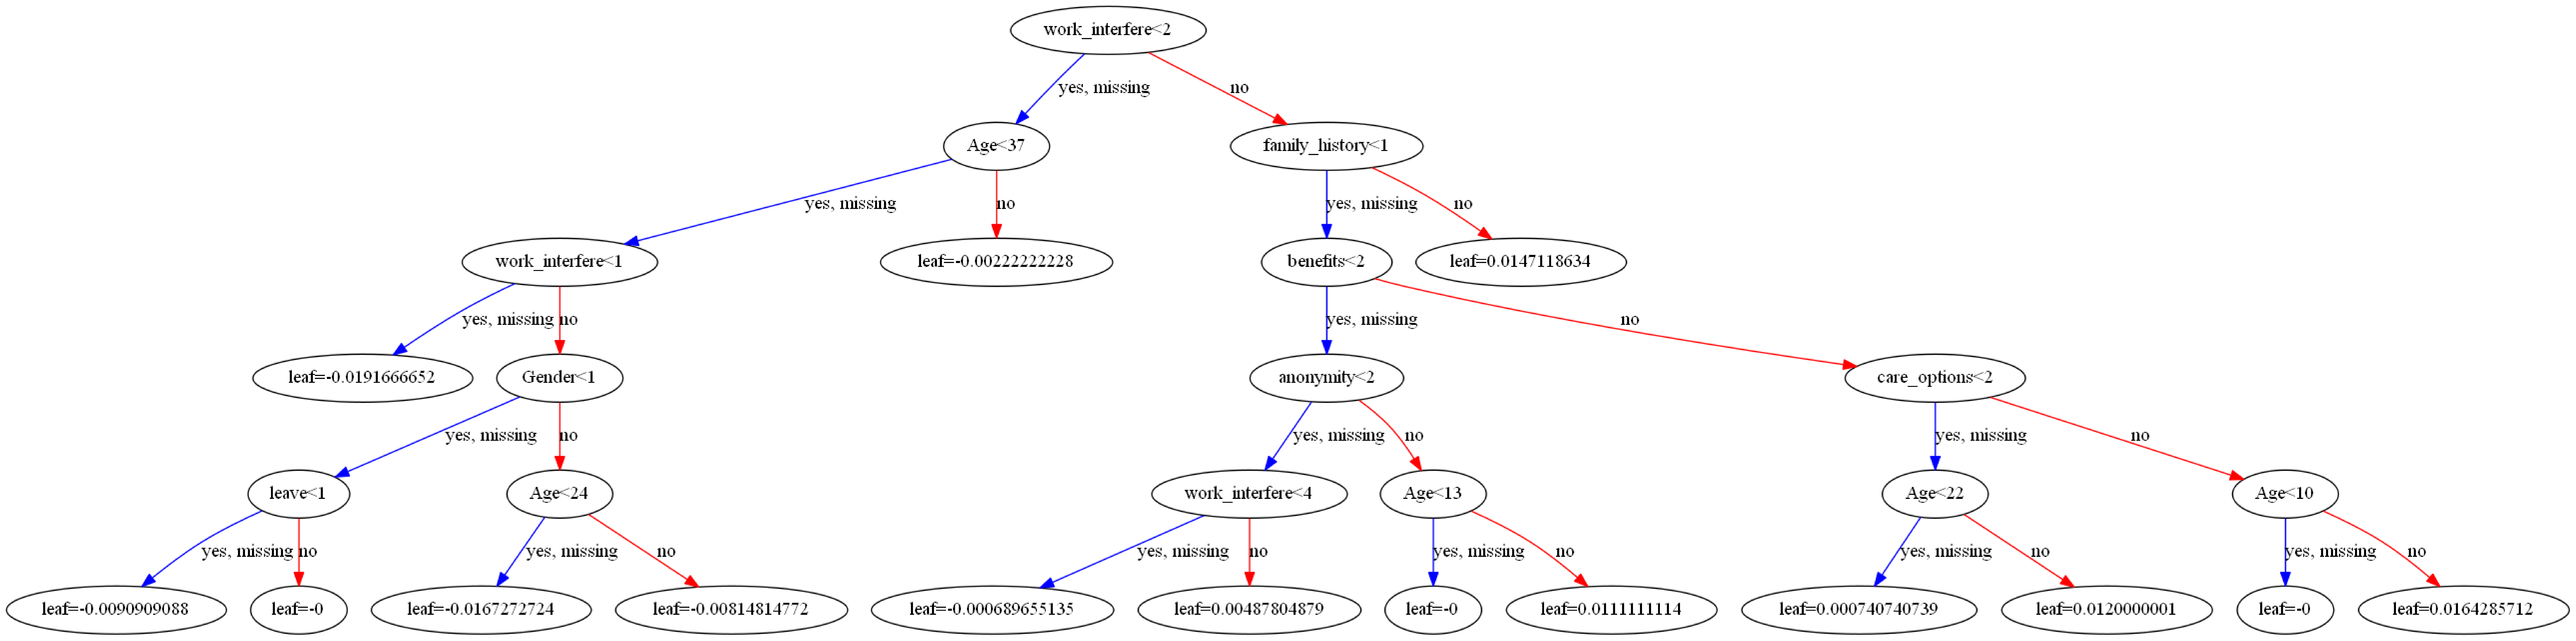

In [115]:
xgb.plot_tree(model,num_trees=0)
fig = plt.gcf()
fig.set_size_inches(250, 150)
fig.savefig('tree.png')

In [116]:
# Function to evaluate xgboost model completely, here we are using the 
# xgboost cross-validation (useTrainCV=True) and checking feature importance
# along with the AUC score

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['treatment'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['treatment'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['treatment'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['treatment'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8491
AUC Score (Train): 0.931176
Model 1 Test Accuracy: 82.28%


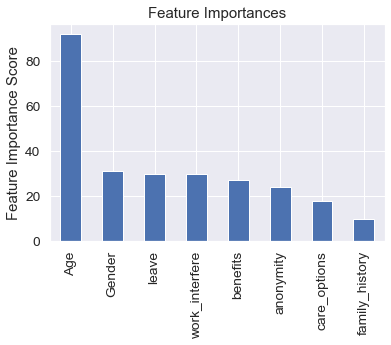

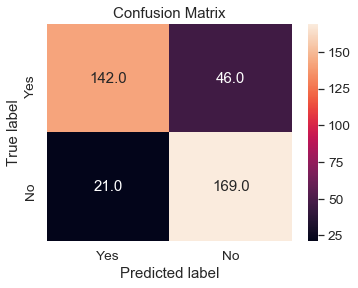

In [117]:
# Giving tested values to the parameters (taken from internet) for classification problems and testing

xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
predictors = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
modelfit(xgb1, df, predictors)
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = metrics.accuracy_score(y_test, predictions)
print("Model 1 Test Accuracy: %.2f%%" % (accuracy * 100.0))
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = ['Yes', 'No'], columns = ['Yes', 'No'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title('Confusion Matrix'.format(ac(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
plt.show()
plt.show()

In [118]:
# Tuning hyperparameters using RandomizedSearcher 
# parameters combinations = 3 x 5 x 3 x 3 x 3 = 405
# 3 fold cross validation = 405 x 3 = 1215
if __name__ == '__main__':
    folds = 3
    param_comb = 5
    params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
    }
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

    random_search = RandomizedSearchCV(xgb1, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=1, cv=skf.split(X_train,y_train), verbose=3, random_state=1001)

    random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.876, total=   0.0s
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.853, total=   0.0s
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.902, total=   0.0s
[CV] subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8, score=0.899, total=   0.0s
[CV] subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, c

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished


In [119]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=5,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=13, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=1.0, verbosity=1)

 Best normalized gini score for 3-fold search with 5 parameter combinations:
0.7810861254682131

 Best hyperparameters:
{'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 5, 'colsample_bytree': 0.6}



Model Report
Accuracy : 0.8403
AUC Score (Train): 0.920398
Model 2 Test Accuracy: 83.07%


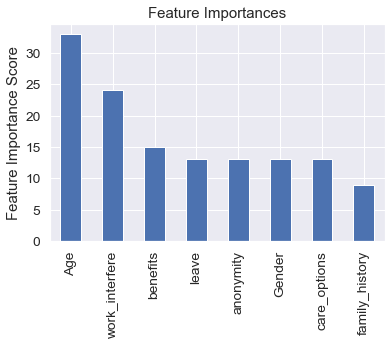

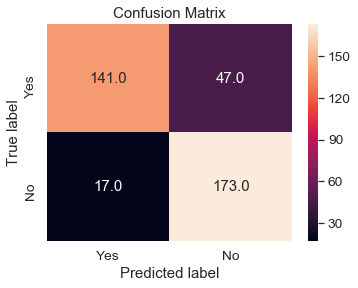

In [120]:
# Trying with the best estimator
xgb2 = xgb.XGBClassifier(
 base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=1,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=13, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1)
predictors = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
modelfit(xgb2, df, predictors)
xgb2.fit(X_train, y_train)
y_pred = xgb2.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = metrics.accuracy_score(y_test, predictions)
print("Model 2 Test Accuracy: %.2f%%" % (accuracy * 100.0))
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = ['Yes', 'No'], columns = ['Yes', 'No'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title('Confusion Matrix'.format(ac(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
plt.show()
plt.show()

In [121]:
# Grid search
grid = GridSearchCV(estimator=xgb1, param_grid=params, scoring='roc_auc', n_jobs=1, cv=skf.split(X_train,y_train), verbose=3 )
grid.fit(X_train, y_train)
print('\n All results:')
print(grid.cv_results_)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6, score=0.900, total=   0.0s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6, score=0.873, total=   0.0s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6, score=0.896, total=   0.0s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8, score=0.895, total=   0.0s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0, score=0.896, total=   0.0s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6, score=0.901, total=   0.0s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6, score=0.874, total=   0.0s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6, score=0.898, total=   0.0s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8, score=0.898, total=

[CV] colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6, score=0.895, total=   0.0s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6, score=0.872, total=   0.0s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6, score=0.899, total=   0.0s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8, score=0.896, total=   0.0s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8, score=0.871, total=   0.0s


[CV]  colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, subsample=0.6, score=0.870, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, subsample=0.6, score=0.894, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, subsample=0.8, score=0.894, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, subsample=0.8, score=0.875, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, subsample=0.8, score=0.897, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytr

[CV]  colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0, score=0.895, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6, score=0.896, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6, score=0.875, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6, score=0.899, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8, score=0.897, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8 
[CV]  colsa

[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=5, subsample=1.0, score=0.878, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=5, subsample=1.0, score=0.898, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.6, score=0.896, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.6, score=0.877, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.6, score=0.898, total=   0.0s
[CV] colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsampl

[CV] colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6, score=0.877, total=   0.0s
[CV] colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6, score=0.898, total=   0.0s
[CV] colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=5, subsample=0.8, score=0.896, total=   0.0s
[CV] colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=5, subsample=0.8, score=0.872, total=   0.0s
[CV] colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=5, subsample=0.8, score=0.902, total=   0.0s
[CV] colsample_bytre

[CV]  colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=0.8, score=0.900, total=   0.0s
[CV] colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=1.0, score=0.900, total=   0.0s
[CV] colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=1.0, score=0.878, total=   0.0s
[CV] colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=1.0, score=0.891, total=   0.0s
[CV] colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=5, subsample=0.6, score=0.895, total=   0.0s
[CV] colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytr

[CV] colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, subsample=0.8, score=0.878, total=   0.0s
[CV] colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, subsample=0.8, score=0.896, total=   0.0s
[CV] colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, subsample=1.0, score=0.895, total=   0.0s
[CV] colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, subsample=1.0, score=0.880, total=   0.0s
[CV] colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, subsample=1.0, score=0.898, total=   0.0s
[CV] colsample_bytre

[CV] colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0, score=0.899, total=   0.0s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6, score=0.899, total=   0.0s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6, score=0.877, total=   0.0s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6, score=0.890, total=   0.0s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8, score=0.898, total=   0.0s
[C

[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.6, score=0.901, total=   0.0s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.6, score=0.876, total=   0.0s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.6, score=0.900, total=   0.0s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.8, score=0.900, total=   0.0s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.8, score=0.872, total=   0.0s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, subsa

[CV]  colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0, score=0.865, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0, score=0.892, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6, score=0.899, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6, score=0.879, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6, score=0.897, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytr

[CV]  colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8, score=0.871, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8, score=0.901, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0, score=0.894, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0, score=0.859, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0, score=0.887, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytr

[CV] colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0, score=0.896, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=1, subsample=0.6, score=0.899, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=1, subsample=0.6, score=0.872, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=1, subsample=0.6, score=0.891, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=1, subsample=0.8, score=0.896, total=   0.0

[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8, score=0.899, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0, score=0.895, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0, score=0.867, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0, score=0.895, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6, score=0.899, total=   0.0s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.

[CV] colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=0.8, score=0.896, total=   0.0s
[CV] colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=0.8, score=0.871, total=   0.0s
[CV] colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=0.8, score=0.898, total=   0.0s
[CV] colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=1.0, score=0.899, total=   0.0s
[CV] colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=1.0, score=0.867, total=   0.0s
[CV] colsample_bytre

[CV]  colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8, score=0.893, total=   0.0s
[CV] colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0, score=0.894, total=   0.0s
[CV] colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0, score=0.865, total=   0.0s
[CV] colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0, score=0.897, total=   0.0s
[CV] colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6, score=0.902, total=   0.0s
[CV] colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytr

[CV]  colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8, score=0.893, total=   0.0s
[CV] colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8, score=0.869, total=   0.0s
[CV] colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8, score=0.888, total=   0.0s
[CV] colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0, score=0.894, total=   0.0s
[CV] colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0, score=0.868, total=   0.0s
[CV] colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytr

[CV] colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.6, score=0.892, total=   0.0s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.6, score=0.870, total=   0.0s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.6, score=0.890, total=   0.0s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.8, score=0.895, total=   0.0s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.8, score=0.859, total=   0.0s


[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6, score=0.871, total=   0.0s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6, score=0.903, total=   0.0s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8, score=0.898, total=   0.0s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8, score=0.869, total=   0.0s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8, score=0.899, total=   0.0s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsa

[CV] colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=5, subsample=1.0, score=0.899, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, subsample=0.6, score=0.889, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, subsample=0.6, score=0.871, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, subsample=0.6, score=0.900, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, subsample=0.8, score=0.899, total=   0.0s
[CV] colsamp

[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6, score=0.889, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6, score=0.874, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6, score=0.899, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8, score=0.899, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8, score=0.867, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8 


[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8, score=0.891, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0, score=0.898, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0, score=0.847, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0, score=0.898, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6, score=0.890, total=   0.0s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6 


[CV]  colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=1, subsample=0.6, score=0.868, total=   0.0s
[CV] colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=1, subsample=0.6, score=0.896, total=   0.0s
[CV] colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=1, subsample=0.8, score=0.891, total=   0.0s
[CV] colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=1, subsample=0.8, score=0.858, total=   0.0s
[CV] colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=1, subsample=0.8, score=0.895, total=   0.0s
[CV] colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytr

[CV] colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.6, score=0.902, total=   0.0s
[CV] colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8, score=0.900, total=   0.0s
[CV] colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8, score=0.866, total=   0.0s
[CV] colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8, score=0.901, total=   0.0s
[CV] colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=1.0, score=0.899, total=   0.0s
[CV] colsa

[CV]  colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, subsample=1.0, score=0.902, total=   0.0s
[CV] colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, subsample=0.6, score=0.889, total=   0.0s
[CV] colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, subsample=0.6, score=0.863, total=   0.0s
[CV] colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, subsample=0.6, score=0.896, total=   0.0s
[CV] colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, subsample=0.8, score=0.884, total=   0.0s
[CV] colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, subsample=0.8 
[CV]  colsa

[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed:   14.0s finished



Model Report
Accuracy : 0.8316
AUC Score (Train): 0.908825
Model 3 Test Accuracy: 82.28%


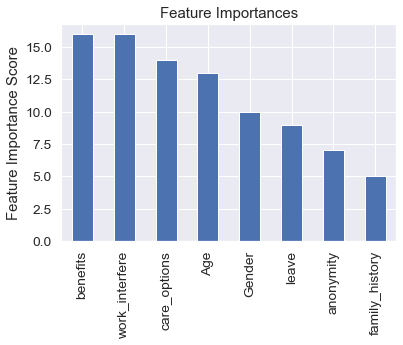

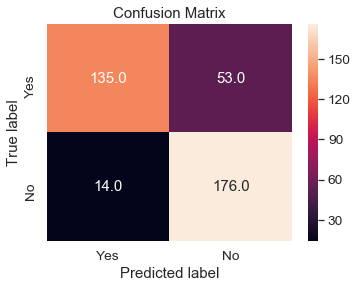

In [122]:
# Trying with gridsearch best estimator
xgb3 = xgb.XGBClassifier(
 base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=13, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1)
predictors = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
modelfit(xgb3, df, predictors)
xgb3.fit(X_train, y_train)
y_pred = xgb3.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = metrics.accuracy_score(y_test, predictions)
print("Model 3 Test Accuracy: %.2f%%" % (accuracy * 100.0))
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = ['Yes', 'No'], columns = ['Yes', 'No'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title('Confusion Matrix'.format(ac(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
plt.show()
plt.show()

In [123]:
# Final index tree for tuned parameters (from randomizedsearch)

xgb.plot_tree(xgb2,num_trees=12)
fig = plt.gcf()
fig.set_size_inches(250, 150)
fig.savefig('tree_randomizedtune.png')

In [124]:
# To understand how the tree splits on each boost,
xgb2.get_booster().dump_model('xgb_model.txt', with_stats=True)
# We take model file with stats.
with open('xgb_model.txt', 'r') as f:
    txt_model = f.read()
print(txt_model)

booster[0]:
0:[family_history<1] yes=1,no=2,missing=1,gain=105.358238,cover=174.75
	1:[care_options<2] yes=3,no=4,missing=3,gain=19.5761719,cover=106.25
		3:[Gender<1] yes=7,no=8,missing=7,gain=5.77570724,cover=75.25
			7:[Age<15] yes=15,no=16,missing=15,gain=3.4666667,cover=10.25
				15:leaf=0.0400000028,cover=5.25
				16:leaf=-0.0666666701,cover=5
			8:[Age<23] yes=17,no=18,missing=17,gain=6.64442062,cover=65
				17:[Age<9] yes=25,no=26,missing=25,gain=2.32146454,cover=54.25
					25:leaf=-0.0451612882,cover=6.75
					26:leaf=-0.117525771,cover=47.5
				18:leaf=-0.0212765969,cover=10.75
		4:[Gender<1] yes=9,no=10,missing=9,gain=4.43832684,cover=31
			9:leaf=0.0814814791,cover=5.75
			10:[Age<15] yes=19,no=20,missing=19,gain=1.07545781,cover=25.25
				19:leaf=-0.0358974375,cover=8.75
				20:leaf=0.00571428565,cover=16.5
	2:[care_options<1] yes=5,no=6,missing=5,gain=2.7926712,cover=68.5
		5:[Age<15] yes=11,no=12,missing=11,gain=1.43591785,cover=24
			11:leaf=0.0938775539,cover=11.25
			